In this project, we will create a simple GAN to generate images similar to the Fashion-MNIST dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
print('tensorflow version: {}'.format(tf.__version__))
print('keras version: {}'.format(keras.__version__))

tensorflow version: 2.1.0
keras version: 2.2.4-tf


## Download the fashion_mnist dataset

In [2]:
# import the fashion_MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print('shape of X_train: {}'.format(X_train.shape))
print('shape of y_train: {}'.format(y_train.shape))
print('shape of X_test: {}'.format(X_test.shape))
print('shape of y_test: {}'.format(y_test.shape))

shape of X_train: (60000, 28, 28)
shape of y_train: (60000,)
shape of X_test: (10000, 28, 28)
shape of y_test: (10000,)


#### Visualize a bunch of random images in the dataset

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
img_idx = np.random.randint(low = 0, high = 60000, size = 16)

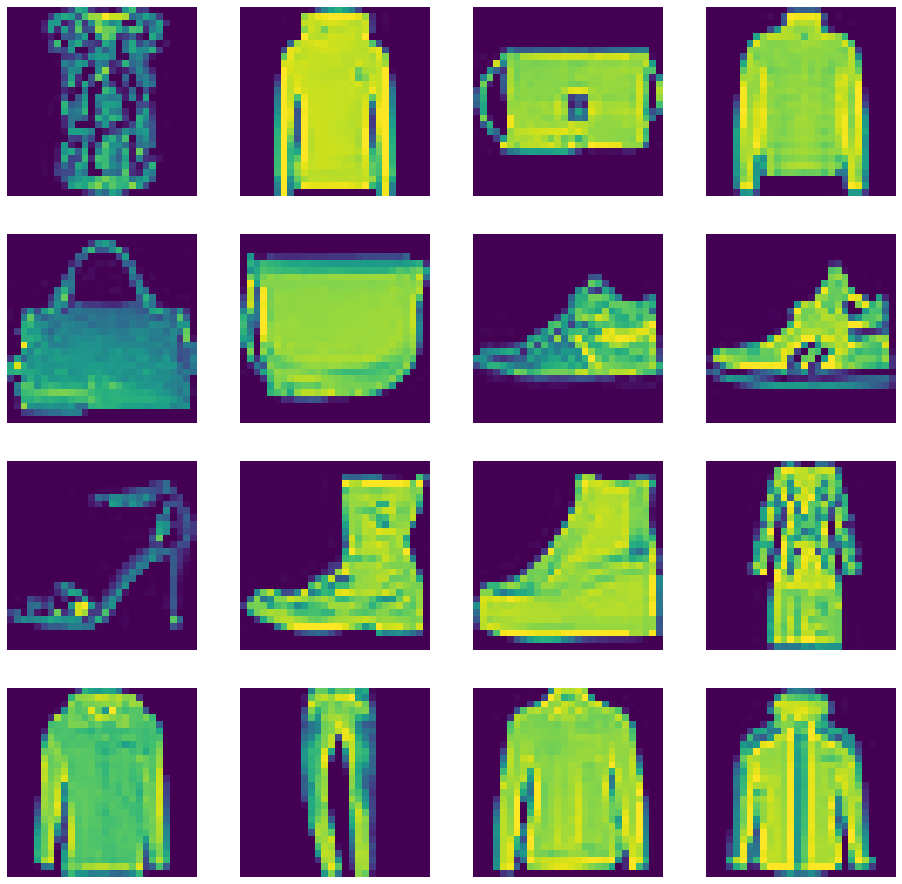

In [6]:
fig, ax = plt.subplots(figsize = (16, 16), nrows = 4, ncols = 4)
ctr = 0
for row in range(4):
    for col in range(4):
        ax[row, col].imshow(X_train[img_idx[ctr]])
        ax[row, col].axis('off')
        ctr+=1
       

## Define a GAN model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization

### Generator:

In [8]:
coding_size = 30
l1 = Dense(100, activation = 'selu', input_shape = (None, coding_size))
l2 = BatchNormalization()
l3 = Dense(150, activation = 'selu')
l4 = BatchNormalization()
l5 = Dense(28*28, activation = 'sigmoid')
l6 = Reshape([28,28])
layer_list = [l1,l2,l3,l4,l5,l6]

generator = Sequential()
for layer in layer_list:
    generator.add(layer)

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 100)         3100      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 100)         400       
_________________________________________________________________
dense_1 (Dense)              (None, None, 150)         15150     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 150)         600       
_________________________________________________________________
dense_2 (Dense)              (None, None, 784)         118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 137,634
Trainable params: 137,134
Non-trainable params: 500
________________________________________________

### Discriminator

In [10]:
from tensorflow.keras.layers import Flatten

In [17]:
l1 = Flatten(input_shape = [28,28])
l2 = Dense(200, activation = keras.layers.LeakyReLU())
l3 = BatchNormalization()
l4 = Dense(150, activation = keras.layers.LeakyReLU())
l5 = BatchNormalization()
l6 = Dense(50, activation = keras.layers.LeakyReLU())
l7 = Dense(1, activation = 'sigmoid')
layer_list = [l1,l2,l3,l4,l5,l6,l7]
discriminator = Sequential()
for layer in layer_list:
    discriminator.add(layer)

In [19]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 200)               157000    
_________________________________________________________________
batch_normalization_14 (Batc (None, 200)               800       
_________________________________________________________________
dense_27 (Dense)             (None, 150)               30150     
_________________________________________________________________
batch_normalization_15 (Batc (None, 150)               600       
_________________________________________________________________
dense_28 (Dense)             (None, 50)                7550      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                

In [21]:
# Combine the generator and the discriminator sequentially to get a gan
gan = Sequential([generator, discriminator])

In [22]:
# compile the discriminator and the gan
loss = 'binary_crossentropy'
optimizer = 'rmsprop'
discriminator.compile(loss = loss, optimizer = optimizer)
# for the purpose of training the generator in the gan, we will 
# make the discriminator non-trainable, when compiling the gan
discriminator.trainable = False
gan.compile(loss = loss, optimizer = optimizer)

## Custom training for the gan

Since the training loop of a gan is rather atypical, we will have to define a custom trainin loop

In [ ]:
def train_gan(gan, training_images, num_epochs = 20, coding_size = 30, batch_size = 32):
    
    generator, discriminator = gan.layers
    for epoch in range(num_epochs):
        print('\repoch: {}/{}'.format(epoch+1, num_epochs), end = '', flush = True)
        print('=', end = '')
        
        for tain_batch in training_images:
            # generate new images
            codings = tf.random.normal(shape = (batch_size, coding_size))
            new_images = generator(codings)
            y_new = tf.constant([[0.]]*batch_size)
        
            # mix with training_images
            len_train = train_batch.shape[0]
            y_train = tf.constant([[1.]]*len_train)
            images = tf.concat([train_batch, new_images])
            labels = tf.concat([y_train, y_new])
        
            # to shuffle the images and labels, we will first have to generate 
            # a shuffled list of their indices and gather images and labels accordingly
            # this is because tf.random.shuffle cannot shuffle more than 1 tensor at a time
            # if we shuffle images and labels seperately, then their relationship will not be maintained
            # the above solution is suggested by Oleksandr Khryplyvenko in the following post:
            # https://stackoverflow.com/questions/44500910/tensorflow-shuffle-split-dataset-of-images-and-labels
        
            total_images = images.shape[0]
            shuffled_idx = tf.random.shuffle(tf.range(total_images))
            images = tf.gather(images, shuffled_idx)
            labels = tf.gather(labels, shuffled_idx)
            
            # phase 1: train the discriminator 
            discriminator.trainable = True
            discriminator.train_on_batch(images, labels)
            
            # phase 2: train the generator
            new_codings = tf.random.normal(shape = (batch_size, coding_size))
            discriminator.trainable = False
            gan.train_on_batch(new_codings, 1 - y_new)
            
                                         